In [53]:
import logging
from itertools import combinations_with_replacement
from typing import Any, Dict, List


import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
import matplotlib.pyplot as plt

from nba_betting.logging.tools import logger
from nba_betting.model.classes import NBA_MODELS
from nba_betting.model.training import preprocess_games
from nba_betting.model.unsupervised_ensemble import UnsupervisedEnsemble
from nba_betting.analysis.visualization import plot_conf_mat

In [2]:
# Hide DEBUG logging statements
logger.setLevel(logging.INFO)

# Split the dataset into train and test using 2018/2019 splits
TRAIN_YEAR = 2018
TEST_YEAR = 2019
X_train, y_train = preprocess_games(TRAIN_YEAR)
X_test, y_test = preprocess_games(TEST_YEAR)


INFO:nba_betting:Processing data for year 2018
INFO:root:Getting game data...
INFO:root:Creating matchups...
INFO:root:Done creating matchups.
INFO:nba_betting:Retrieved data for year 2018.
Columns: Index(['level_0', 'index', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'GAMES_PLAYED', 'ALLOWED_PTS',
       'ALLOWED_FGM', 'ALLOWED_FGA', 'ALLOWED_FG_PCT', 'ALLOWED_FG3M',
       'ALLOWED_FG3A', 'ALLOWED_FG3_PCT', 'ALLOWED_FTM', 'ALLOWED_FTA',
       'ALLOWED_FT_PCT', 'ALLOWED_OREB', 'ALLOWED_DREB', 'ALLOWED_REB',
       'ALLOWED_AST', 'ALLOWED_STL', 'ALLOWED_BLK', 'ALLOWED_TOV',
       'ALLOWED_PF', 'ALLOWED_PLUS_MINUS', 'ALLOWED_GAMES_PLAYED', 'OPP_PTS',
       'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK', 'OPP_TOV',
     

# Plain Voting Classifier

### Train VotingClassifier

In [55]:
logger.info(
    "Training VotingClassifier with: %r", [model_name for model_name in NBA_MODELS]
)
param_grid: Dict[str, List[Any]] = {
    "weights": list(
        set(
            tuple(np.divide(weight_combination, sum(weight_combination)))
            for weight_combination in combinations_with_replacement(
                [i for i in range(2)], len(NBA_MODELS)
            )
            if sum(weight_combination) != 0
        )
    ),
}
logger.info("Using grid search wih params: %r", param_grid)
voting_cls: GridSearchCV = GridSearchCV(
    estimator=VotingClassifier(
        estimators=[(model_name, model()) for model_name, model in NBA_MODELS.items()],
        voting="soft",
    ),
    param_grid=param_grid,
    cv=5,
)
voting_cls = voting_cls.fit(X_train, y_train)


INFO:nba_betting:Training VotingClassifier with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:nba_betting:Using grid search wih params: {'weights': [(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2), (0.0, 0.0, 0.0, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111), (0.0, 0.0, 0.0, 0.0, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125), (0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333

In [56]:
logger.info(
    "Grid search complete. GridSearchCV best params: %r", voting_cls.best_params_
)

INFO:nba_betting:Grid search complete. GridSearchCV best params: {'weights': (0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)}


In [57]:
logger.info(
    "Training set score: %s",
    accuracy_score(y_train, voting_cls.predict(X_train)),
)
logger.info(classification_report(y_train, voting_cls.predict(X_train)))


INFO:nba_betting:Training set score: 0.950369155045119
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.96      0.94      0.95      1219
           W       0.94      0.96      0.95      1219

    accuracy                           0.95      2438
   macro avg       0.95      0.95      0.95      2438
weighted avg       0.95      0.95      0.95      2438



In [58]:
logger.info(
    "Testing set score: %s",
    accuracy_score(y_test, voting_cls.predict(X_test)),
)
logger.info(classification_report(y_test, voting_cls.predict(X_test)))


INFO:nba_betting:Testing set score: 0.6266735324407827
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.65      0.55      0.60       971
           W       0.61      0.70      0.65       971

    accuracy                           0.63      1942
   macro avg       0.63      0.63      0.62      1942
weighted avg       0.63      0.63      0.62      1942



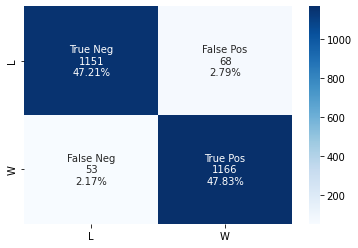

In [59]:
plot_conf_mat(y_train, voting_cls.predict(X_train))

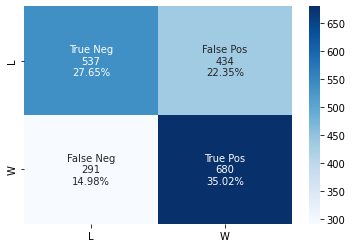

In [60]:
plot_conf_mat(y_test, voting_cls.predict(X_test))

Text(0, 0.5, 'True Positive Rate')

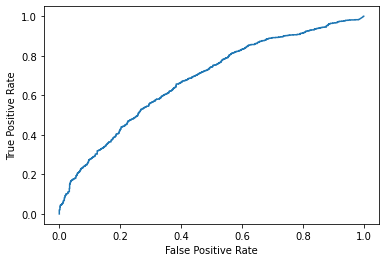

In [62]:
# ROC Curve

voting_cls_pred_proba = voting_cls.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  voting_cls_pred_proba, pos_label="W")
auc = roc_auc_score(y_test, voting_cls_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Unsupervised Ensemble

### Train ensemble with Ridge or RandomForest learners for corrections and weights

In [13]:
ridge_params: Dict[str, List[Any]] = {
    "scale": [RobustScaler(), "passthrough"],
    "poly__degree": [1, 2, 3],
    "pca": [PCA(n_components="mle"), PCA(n_components=40), "passthrough"],
    "ridge__tol": [0.001, 0.01],
}
random_forest_params = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [1, 2, 3],
    "ccp_alpha": [0, 0.05, 0.1],
}

## Unsupervised Ensemble with

#### Ridge regression as correction model and RandomForestRegressor as weights model

In [63]:
logger.info(
    "Training UnsupervisedEnsemble with: %r", [model_name for model_name in NBA_MODELS]
)

logging.info(
    "Using Ridge as correction model and RandomForestRegressor as weights model"
)
unsupervised_ensemble = UnsupervisedEnsemble(
    models=[_() for _ in NBA_MODELS.values()],
    correction_learner=GridSearchCV(
        estimator=Pipeline(
            [
                ("scale", RobustScaler()),
                ("poly", PolynomialFeatures()),
                ("pca", PCA()),
                ("ridge", Ridge(fit_intercept=False)),
            ]
        ),
        cv=3,
        param_grid=ridge_params,
        n_jobs=4,
    ),
    weight_learner=GridSearchCV(
        estimator=RandomForestRegressor(),
        cv=3,
        param_grid=random_forest_params,
        n_jobs=4,
    ),
)
unsupervised_ensemble.fit(X_train, y_train)


INFO:nba_betting:Training UnsupervisedEnsemble with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:root:Using Ridge as correction model and RandomForestRegressor as weights model
/Users/Aaditya/git/ds4420_nba_betting/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [64]:
logger.info(
    "correction model best params: %r",
    unsupervised_ensemble.correction_model.best_params_,
)
logger.info(
    "weight model best params: %r",
    unsupervised_ensemble.weight_learner.best_params_,
)

INFO:nba_betting:correction model best params: {'pca': 'passthrough', 'poly__degree': 1, 'ridge__tol': 0.001, 'scale': 'passthrough'}
INFO:nba_betting:weight model best params: {'ccp_alpha': 0, 'max_depth': 1, 'n_estimators': 10}


##### Results

In [65]:
logger.info(
    "Training set score: %s",
    accuracy_score(y_train, unsupervised_ensemble.predict(X_train)),
)
logger.info(classification_report(y_train, unsupervised_ensemble.predict(X_train)))


INFO:nba_betting:Training set score: 0.6817063166529943
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.69      0.67      0.68      1219
           W       0.68      0.69      0.69      1219

    accuracy                           0.68      2438
   macro avg       0.68      0.68      0.68      2438
weighted avg       0.68      0.68      0.68      2438



In [66]:
logger.info(
    "Testing set score: %s",
    accuracy_score(y_test, unsupervised_ensemble.predict(X_test)),
)
logger.info(classification_report(y_test, unsupervised_ensemble.predict(X_test)))


INFO:nba_betting:Testing set score: 0.6374871266735325
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.64      0.64      0.64       971
           W       0.64      0.64      0.64       971

    accuracy                           0.64      1942
   macro avg       0.64      0.64      0.64      1942
weighted avg       0.64      0.64      0.64      1942



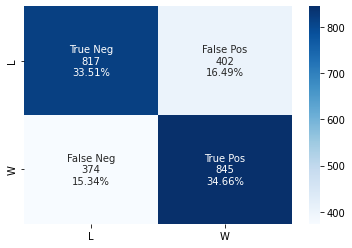

In [67]:
plot_conf_mat(y_train, unsupervised_ensemble.predict(X_train))

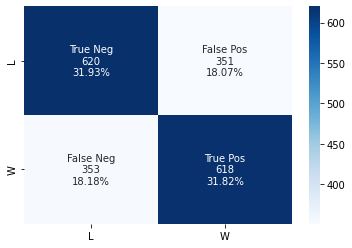

In [68]:
plot_conf_mat(y_test, unsupervised_ensemble.predict(X_test))

Text(0, 0.5, 'True Positive Rate')

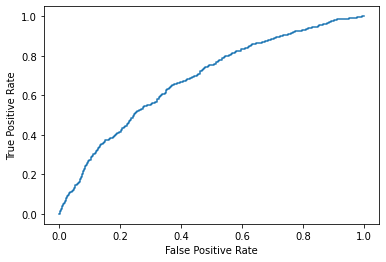

In [74]:
# ROC Curve

unsupervised_ensemble_pred_proba = unsupervised_ensemble.predict_proba(X_test).values[::,0]
fpr, tpr, _ = roc_curve(y_test, unsupervised_ensemble_pred_proba, pos_label="W")
auc = roc_auc_score(y_test, unsupervised_ensemble_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Unsupervised Ensemble with

#### Ridge regression as correction and weights model

In [24]:
logger.info(
    "Training UnsupervisedEnsemble with: %r", [model_name for model_name in NBA_MODELS]
)

logging.info(
    "Using Ridge as correction model and as weights model"
)
unsupervised_ensemble = UnsupervisedEnsemble(
    models=[_() for _ in NBA_MODELS.values()],
    correction_learner=GridSearchCV(
        estimator=Pipeline(
            [
                ("scale", RobustScaler()),
                ("poly", PolynomialFeatures()),
                ("pca", PCA()),
                ("ridge", Ridge(fit_intercept=False)),
            ]
        ),
        cv=3,
        param_grid=ridge_params,
        n_jobs=4,
    ),
    weight_learner=GridSearchCV(
        estimator=Pipeline(
            [
                ("scale", RobustScaler()),
                ("poly", PolynomialFeatures()),
                ("pca", PCA()),
                ("ridge", Ridge(fit_intercept=False)),
            ]
        ),
        cv=3,
        param_grid=ridge_params,
        n_jobs=4,
    ),
)
unsupervised_ensemble.fit(X_train, y_train)


INFO:nba_betting:Training UnsupervisedEnsemble with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:root:Using Ridge as correction model and as weights model
/Users/Aaditya/git/ds4420_nba_betting/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [29]:
logger.info(
    "correction model best params: %r",
    unsupervised_ensemble.correction_model.best_params_,
)
logger.info(
    "weight model best params: %r",
    unsupervised_ensemble.weight_learner.best_params_,
)

INFO:nba_betting:correction model best params: {'pca': 'passthrough', 'poly__degree': 1, 'ridge__tol': 0.001, 'scale': 'passthrough'}
INFO:nba_betting:weight model best params: {'pca': PCA(n_components=40), 'poly__degree': 3, 'ridge__tol': 0.001, 'scale': RobustScaler()}


In [25]:
logger.info(
    "Training set score: %s",
    accuracy_score(y_train, unsupervised_ensemble.predict(X_train)),
)
logger.info(classification_report(y_train, unsupervised_ensemble.predict(X_train)))


INFO:nba_betting:Training set score: 0.5607054963084496
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.56      0.56      0.56      1219
           W       0.56      0.56      0.56      1219

    accuracy                           0.56      2438
   macro avg       0.56      0.56      0.56      2438
weighted avg       0.56      0.56      0.56      2438



In [26]:
logger.info(
    "Testing set score: %s",
    accuracy_score(y_test, unsupervised_ensemble.predict(X_test)),
)
logger.info(classification_report(y_test, unsupervised_ensemble.predict(X_test)))


INFO:nba_betting:Testing set score: 0.6179196704428425
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.62      0.63      0.62       971
           W       0.62      0.61      0.61       971

    accuracy                           0.62      1942
   macro avg       0.62      0.62      0.62      1942
weighted avg       0.62      0.62      0.62      1942



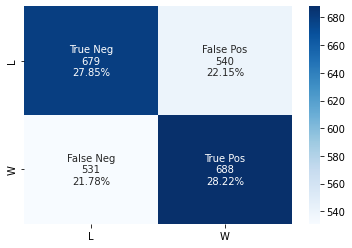

In [27]:
plot_conf_mat(y_train, unsupervised_ensemble.predict(X_train))

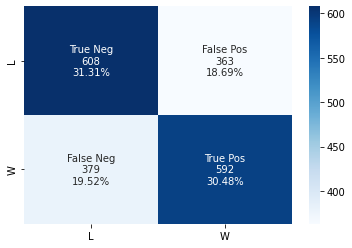

In [28]:
plot_conf_mat(y_test, unsupervised_ensemble.predict(X_test))

## Unsupervised Ensemble with

#### RandomForestRegressor as correction and weights model

In [30]:
logger.info(
    "Training UnsupervisedEnsemble with: %r", [model_name for model_name in NBA_MODELS]
)

logging.info(
    "Using RandomForestRegressor as correction and weights model"
)
unsupervised_ensemble = UnsupervisedEnsemble(
    models=[_() for _ in NBA_MODELS.values()],
    correction_learner=GridSearchCV(
        estimator=RandomForestRegressor(),
        cv=3,
        param_grid=random_forest_params,
        n_jobs=4,
    ),
    weight_learner=GridSearchCV(
        estimator=RandomForestRegressor(),
        cv=3,
        param_grid=random_forest_params,
        n_jobs=4,
    ),
)
unsupervised_ensemble.fit(X_train, y_train)


INFO:nba_betting:Training UnsupervisedEnsemble with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:root:Using RandomForestRegressor as correction and weights model
/Users/Aaditya/git/ds4420_nba_betting/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  

In [31]:
logger.info(
    "correction model best params: %r",
    unsupervised_ensemble.correction_model.best_params_,
)
logger.info(
    "weight model best params: %r",
    unsupervised_ensemble.weight_learner.best_params_,
)

INFO:nba_betting:correction model best params: {'ccp_alpha': 0, 'max_depth': 3, 'n_estimators': 50}
INFO:nba_betting:weight model best params: {'ccp_alpha': 0, 'max_depth': 1, 'n_estimators': 10}


In [32]:
logger.info(
    "Training set score: %s",
    accuracy_score(y_train, unsupervised_ensemble.predict(X_train)),
)
logger.info(classification_report(y_train, unsupervised_ensemble.predict(X_train)))


INFO:nba_betting:Training set score: 0.6558654634946678
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.66      0.65      0.66      1219
           W       0.66      0.66      0.66      1219

    accuracy                           0.66      2438
   macro avg       0.66      0.66      0.66      2438
weighted avg       0.66      0.66      0.66      2438



In [33]:
logger.info(
    "Testing set score: %s",
    accuracy_score(y_test, unsupervised_ensemble.predict(X_test)),
)
logger.info(classification_report(y_test, unsupervised_ensemble.predict(X_test)))


INFO:nba_betting:Testing set score: 0.641091658084449
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.65      0.62      0.63       971
           W       0.64      0.66      0.65       971

    accuracy                           0.64      1942
   macro avg       0.64      0.64      0.64      1942
weighted avg       0.64      0.64      0.64      1942



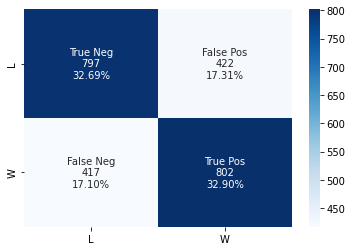

In [34]:
plot_conf_mat(y_train, unsupervised_ensemble.predict(X_train))

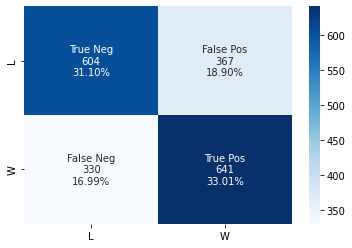

In [35]:
plot_conf_mat(y_test, unsupervised_ensemble.predict(X_test))

## Unsupervised Ensemble with

#### RandomForestRegressor as correction model and Ridge regression as weights model

In [36]:
logger.info(
    "Training UnsupervisedEnsemble with: %r", [model_name for model_name in NBA_MODELS]
)

logging.info(
    "Using RandomForestRegressor as correction model and Ridge as weights model"
)
unsupervised_ensemble = UnsupervisedEnsemble(
    models=[_() for _ in NBA_MODELS.values()],
    correction_learner=GridSearchCV(
        estimator=RandomForestRegressor(),
        cv=3,
        param_grid=random_forest_params,
        n_jobs=4,
    ),
    weight_learner=GridSearchCV(
        estimator=Pipeline(
            [
                ("scale", RobustScaler()),
                ("poly", PolynomialFeatures()),
                ("pca", PCA()),
                ("ridge", Ridge(fit_intercept=False)),
            ]
        ),
        cv=3,
        param_grid=ridge_params,
        n_jobs=4,
    ),
)
unsupervised_ensemble.fit(X_train, y_train)


INFO:nba_betting:Training UnsupervisedEnsemble with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:root:Using RandomForestRegressor as correction model and Ridge as weights model
/Users/Aaditya/git/ds4420_nba_betting/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [37]:
logger.info(
    "correction model best params: %r",
    unsupervised_ensemble.correction_model.best_params_,
)
logger.info(
    "weight model best params: %r",
    unsupervised_ensemble.weight_learner.best_params_,
)


INFO:nba_betting:correction model best params: {'ccp_alpha': 0, 'max_depth': 3, 'n_estimators': 100}
INFO:nba_betting:weight model best params: {'pca': PCA(n_components=40), 'poly__degree': 3, 'ridge__tol': 0.001, 'scale': RobustScaler()}


In [38]:
logger.info(
    "Training set score: %s",
    accuracy_score(y_train, unsupervised_ensemble.predict(X_train)),
)
logger.info(classification_report(y_train, unsupervised_ensemble.predict(X_train)))


INFO:nba_betting:Training set score: 0.7973748974569319
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.80      0.79      0.80      1219
           W       0.79      0.80      0.80      1219

    accuracy                           0.80      2438
   macro avg       0.80      0.80      0.80      2438
weighted avg       0.80      0.80      0.80      2438



In [50]:
logger.info(
    "Testing set score: %s",
    accuracy_score(y_test, unsupervised_ensemble.predict(X_test)),
)
logger.info(classification_report(y_test, unsupervised_ensemble.predict(X_test)))


INFO:nba_betting:Testing set score: 0.619979402677652
INFO:nba_betting:              precision    recall  f1-score   support

           L       0.62      0.64      0.63       971
           W       0.62      0.60      0.61       971

    accuracy                           0.62      1942
   macro avg       0.62      0.62      0.62      1942
weighted avg       0.62      0.62      0.62      1942



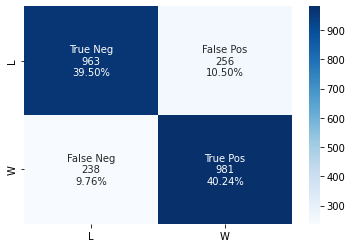

In [40]:
plot_conf_mat(y_train, unsupervised_ensemble.predict(X_train))

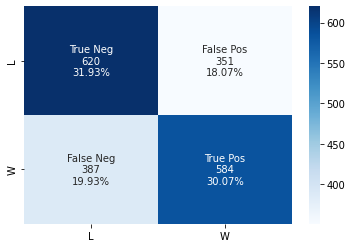

In [41]:
plot_conf_mat(y_test, unsupervised_ensemble.predict(X_test))